In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/lynnej/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import lsst.sims.maf.db as db
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plot

In [4]:
opsdb = db.OpsimDatabase('/Users/lynnej/opsim/db/minion_1016_sqlite.db')

In [5]:
outDir = 'sky_compare'
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
filtercolors = {'u': 'c', 'g': 'g', 'r': 'y', 'i':'r', 'z': 'm', 'y': 'k'}

In [6]:
data = {}
for f in filterlist:
    data[f] = opsdb.fetchMetricData(colnames=('expMJD', 'lst', 'fieldRA', 'fieldDec', 'altitude', 'azimuth',
                                              'dist2Moon', 'moonPhase', 'moonAlt', 'sunAlt', 'FWHMeff', 'airmass',
                                              'filtSkyBrightness', 'fiveSigmaDepth', 'sims_skybrightness', 'sims_m5'),
                                    sqlconstraint='filter="%s"' % f)                                   

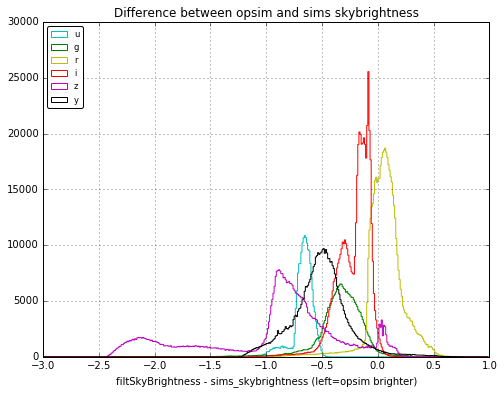

In [8]:
plt.figure(figsize=(8, 6))
b = np.arange(-3, 1, 0.01)
for f in filterlist:
    dsky = data[f]['filtSkyBrightness'] - data[f]['sims_skybrightness']
    n, b, p = plt.hist(dsky, bins=b, histtype='step', label=f, color=filtercolors[f])
plt.xlabel('filtSkyBrightness - sims_skybrightness (left=opsim brighter)')
plt.title('Difference between opsim and sims skybrightness')
plt.grid(True)
plt.legend(loc='upper left', fancybox=True, fontsize='smaller')

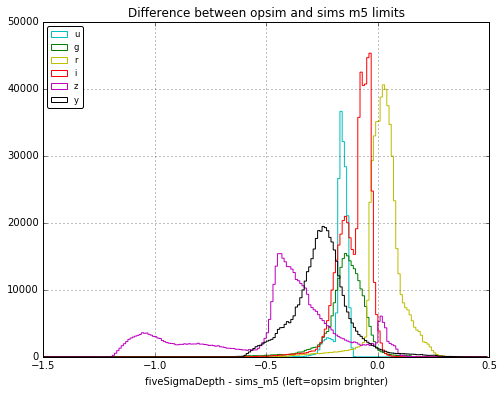

In [9]:
plt.figure(figsize=(8, 6))
b = np.arange(-1.5, 0.5, 0.01)
for f in filterlist:
    dmag = data[f]['fiveSigmaDepth'] - data[f]['sims_m5']
    n, b, p = plt.hist(dmag, bins=b, histtype='step', label=f, color=filtercolors[f])
plt.xlabel('fiveSigmaDepth - sims_m5 (left=opsim brighter)')
plt.title('Difference between opsim and sims m5 limits')
plt.grid(True)
plt.legend(loc='upper left', fancybox=True, fontsize='smaller')

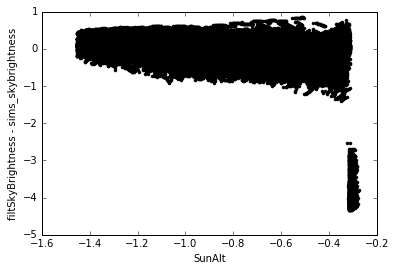

In [44]:
f = 'r'
dsky = data[f]['filtSkyBrightness'] - data[f]['sims_skybrightness']
plt.figure()
plt.plot(data[f]['sunAlt'], dsky, 'k.')
plt.xlabel('SunAlt')
plt.ylabel('filtSkyBrightness - sims_skybrightness')

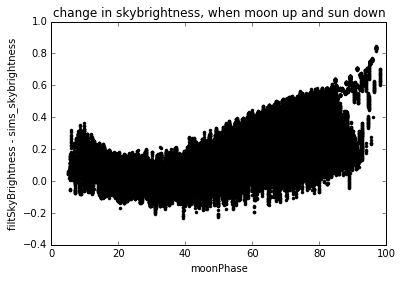

In [51]:
plt.figure()
notwilight = np.where(data[f]['sunAlt'] < -0.4, True, False)
moonhigh = np.where(data[f]['moonAlt'] > 0, True, False)
both = np.where((notwilight) & (moonhigh))
k = 'moonPhase'
plt.plot(data[f][k][both], dsky[both], 'k.')
plt.xlabel(k)
plt.ylabel('filtSkyBrightness - sims_skybrightness')
plt.title('change in skybrightness, when moon up and sun down')